In [1]:
import os
import pandas as pd
import glob
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense


/home/rishabh/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
PATH = os.path.abspath(os.path.join('..', 'images'))
images = glob.glob(os.path.join(PATH, "*.png"))

In [4]:
labels = pd.read_csv('sample_labels.csv')
PATH = os.path.abspath(os.path.join('', 'images'))
images = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join(PATH, "*.png"))}

labels['path'] = labels['Image Index'].map(images.get)
labels['Patient Age'] = labels['Patient Age'].map(lambda x: int(x[:-1]))
label_counts = labels['Finding Labels'].value_counts()[:15]
labels['Finding Labels'] = labels['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*labels['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]


#the classes as the headers
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        labels[c_label] = labels['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
        
MIN_CASES = 99
all_labels = [c_label for c_label in all_labels if labels[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(labels[c_label].sum())) for c_label in all_labels])

('Clean Labels (11)', [('Atelectasis', 508), ('Cardiomegaly', 141), ('Consolidation', 226), ('Edema', 118), ('Effusion', 644), ('Emphysema', 127), ('Infiltration', 967), ('Mass', 284), ('Nodule', 313), ('Pleural_Thickening', 176), ('Pneumothorax', 271)])


In [5]:
sample_weights = labels['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
labels = labels.sample(5606, weights=sample_weights)

In [ ]:
#one hot coding

In [6]:
labels['disease_vec'] = labels.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [7]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(labels, 
                                test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = labels['Finding Labels'].map(lambda x: x[:4]))
print('train', train.shape[0], 'validation', validation.shape[0])

('train', 4204, 'validation', 1402)


In [8]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [9]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]    
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [10]:
train_gen = flow_from_dataframe(core_idg, train, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)) # one big batch



## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4204 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images


In [11]:
def create_model(all_labels):
    classifier = Sequential()
# Step 1 - Convolution
    classifier.add(Conv2D(128, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
# Step 2 - Pooling
    classifier.add(GlobalAveragePooling2D())
# Step 3 - Dense layer
    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dense(units = len(all_labels), activation = 'sigmoid'))
# Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier
#for categorical entropy, as the loss function accuracy was low, ans activation as softmax, acuuracy was low,
# for LetNET the accuracy around 12-15%

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]


In [13]:
classifier = create_model(all_labels)
history = classifier.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 128)     1280      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 72,971
Trainable params: 72,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
100/100 [==============================] - 788s 8s/step - loss: 0.2804 - acc: 0.9312 - val_loss: 0.2316 - val_acc: 0.9357

Epoch 00001: val_loss improved from inf to 0.23159, saving model to xray_class_weights.best.hdf5
Epoch 2/5
100/100 [=====================

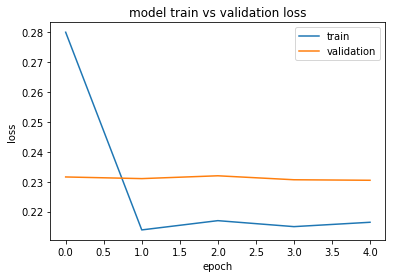

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [14]:
pred_Y = classifier.predict(test_X, batch_size = 32, verbose = True)

256/256 [==============================] - 14s 54ms/step


In [15]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 9.77%, PDx: 9.04%
Cardiomegaly: Dx: 3.91%, PDx: 2.99%
Consolidation: Dx: 2.73%, PDx: 4.43%
Edema: Dx: 2.73%, PDx: 2.94%
Effusion: Dx: 11.33%, PDx: 10.96%
Emphysema: Dx: 3.52%, PDx: 2.53%
Infiltration: Dx: 14.45%, PDx: 18.45%
Mass: Dx: 6.64%, PDx: 5.23%
Nodule: Dx: 4.69%, PDx: 4.73%
Pleural_Thickening: Dx: 3.91%, PDx: 2.91%
Pneumothorax: Dx: 7.03%, PDx: 3.91%


In [16]:
sickest_idx = np.argsort(np.sum(test_Y, 1)>1)
for idx in sickest_idx:
    original_tags = [n_class[:4] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_tag = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    print('Original: '+', '.join(original_tags)+'\nPredicted: '+', '.join(pred_tag))
    print('\n')

Original: Emph
Predicted: Emph: 2%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Card
Predicted: Card: 3%


Original: 
Predicted: 


Original: Mass
Predicted: Mass: 6%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Mass
Predicted: Mass: 4%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Atel
Predicted: Atel: 9%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Infi
Predicted: Infi:19%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Edem
Predicted: Edem: 4%


Original: Atel
Predicted: Atel: 9%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Card
Predicted: Card: 3%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Mass
Predicted: Mass: 5%


Origi

In [14]:
model = create_model(all_labels)
model.load_weights('xray_class_weights.best.hdf5')
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('images/00000468_005.png', target_size = (256, 256), grayscale = True)

test_image = image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 128)     1280      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                5643      
Total params: 72,971
Trainable params: 72,971
Non-trainable params: 0
_________________________________________________________________


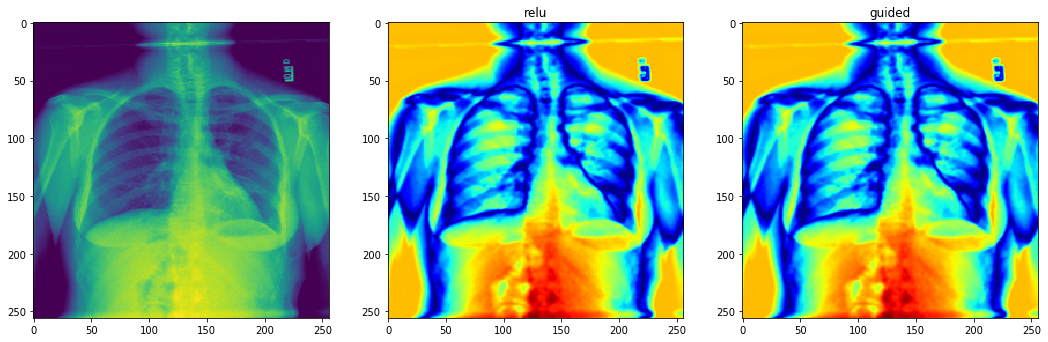

In [17]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10): 
 indices = np.where(test_Y[:, class_idx] == 0.)[0]
 idx = indices[0]
f, ax = plt.subplots(1,3)
ax[0].imshow(test_X[idx][...,0])
 
for i, modifier in enumerate([None,'guided']):
    grads = visualize_cam(model, layer_idx=2, filter_indices=class_idx, 
    seed_input=test_X[idx], backprop_modifier=modifier) 
    if modifier is None:
        modifier = 'relu'
    ax[i+1].set_title(modifier) 
    ax[i+1].imshow(grads, cmap='jet')

In [20]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [21]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [22]:
train_gen = flow_from_dataframe(core_idg, train, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               validation, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)) # one big batch



## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4204 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images


In [23]:
t_x, t_y = next(train_gen)

In [24]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Input
#create the base pre-trained model
def create_Inception_model(t_x, t_y, all_labels):
    base_model = InceptionV3(input_shape =  t_x.shape[1:], include_top=False, weights = None)
    classifier = Sequential()
    classifier.add(base_model)
    # Step 2 - Pooling
    classifier.add(GlobalAveragePooling2D())
    # Step 3 - Dense layer
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = len(all_labels), activation = 'sigmoid'))
    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mae'])
    classifier.summary()
    return classifier



In [26]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best1.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]


In [25]:
classifier = create_Inception_model(t_x, t_y, all_labels)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802208  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 22,065,899
Trainable params: 22,031,467
Non-trainable params: 34,432
_________________________________________________________________


In [27]:

history = classifier.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)


Epoch 1/5
100/100 [==============================] - 4334s 43s/step - loss: 0.2478 - acc: 0.9324 - mean_absolute_error: 0.1221 - val_loss: 0.3058 - val_acc: 0.9393 - val_mean_absolute_error: 0.1143

Epoch 00001: val_loss improved from inf to 0.30579, saving model to xray_class_weights.best1.hdf5
Epoch 2/5
100/100 [==============================] - 4305s 43s/step - loss: 0.2230 - acc: 0.9399 - mean_absolute_error: 0.1100 - val_loss: 0.4534 - val_acc: 0.9094 - val_mean_absolute_error: 0.1921

Epoch 00002: val_loss did not improve
Epoch 3/5
100/100 [==============================] - 4310s 43s/step - loss: 0.2248 - acc: 0.9362 - mean_absolute_error: 0.1159 - val_loss: 0.2855 - val_acc: 0.9123 - val_mean_absolute_error: 0.2096

Epoch 00003: val_loss improved from 0.30579 to 0.28548, saving model to xray_class_weights.best1.hdf5
Epoch 4/5
100/100 [==============================] - 4301s 43s/step - loss: 0.2174 - acc: 0.9384 - mean_absolute_error: 0.1114 - val_loss: 0.8108 - val_acc: 0.9393 -

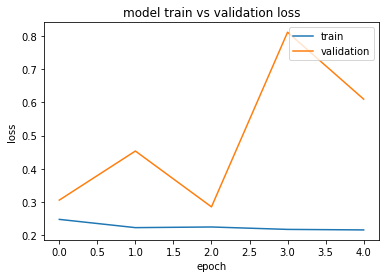

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [16]:
pred_Y = classifier.predict(test_X, batch_size = 32, verbose = True)

256/256 [==============================] - 111s 435ms/step


In [17]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 10.94%, PDx: 9.85%
Cardiomegaly: Dx: 2.34%, PDx: 2.52%
Consolidation: Dx: 5.08%, PDx: 4.26%
Edema: Dx: 1.95%, PDx: 3.73%
Effusion: Dx: 11.72%, PDx: 18.63%
Emphysema: Dx: 1.56%, PDx: 3.85%
Infiltration: Dx: 16.02%, PDx: 18.05%
Mass: Dx: 2.73%, PDx: 3.77%
Nodule: Dx: 6.25%, PDx: 5.73%
Pleural_Thickening: Dx: 3.12%, PDx: 3.02%
Pneumothorax: Dx: 6.64%, PDx: 4.77%


In [18]:
sickest_idx = np.argsort(np.sum(test_Y, 1)>1)
for idx in sickest_idx:
    original_tags = [n_class[:4] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_tag = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    print('Original: '+', '.join(original_tags)+'\nPredicted: '+', '.join(pred_tag))
    print('\n')

Original: 
Predicted: 


Original: Effu
Predicted: Effu:14%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Nodu
Predicted: Nodu: 7%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Infi
Predicted: Infi:21%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Nodu
Predicted: Nodu: 7%


Original: Effu
Predicted: Effu:15%


Original: Effu
Predicted: Effu:14%


Original: Atel
Predicted: Atel: 9%


Original: 
Predicted: 


Original: 
Predicted: 


Original: Infi
Predicted: Infi:20%


Original: 
Predicted: 


Original: Cons
Predicted: Cons: 0%


Original: 
Predicted: 


Original: Atel
Predicted: Atel: 9%


Original: Atel
Predicted: Atel: 5%


Original: Card
Predicted: Card: 2%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: Edem
Predicted: Edem: 3%


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicted: 


Original: 
Predicte

In [13]:
model = create_Inception_model(t_x, t_y,all_labels)
model.load_weights('xray_class_weights.best1.hdf5')
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('images/00000468_005.png', target_size = (256, 256), grayscale = True)

test_image = image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802208  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1419      
Total params: 22,065,899
Trainable params: 22,031,467
Non-trainable params: 34,432
_________________________________________________________________


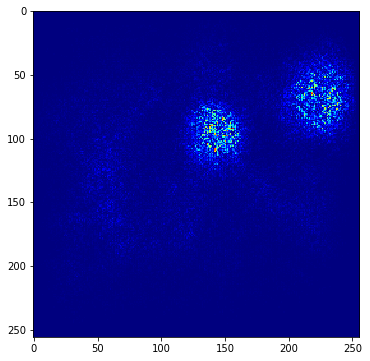

In [19]:
class_idx = 0
indices = np.where(test_Y[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(test_X[idx][..., 0])

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_X[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

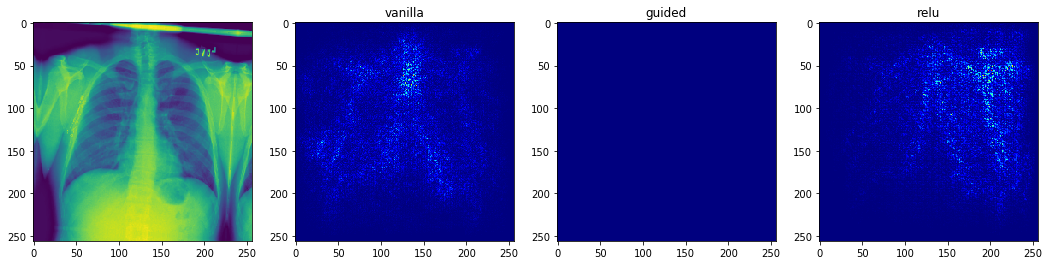

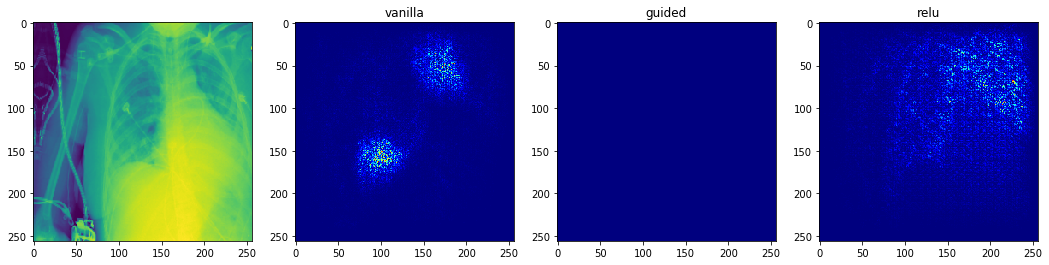

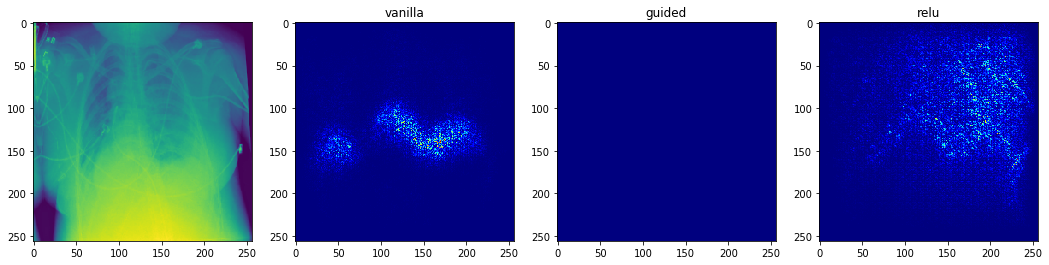

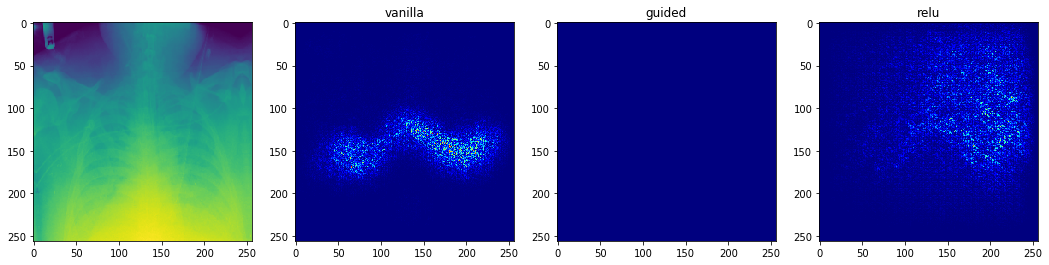

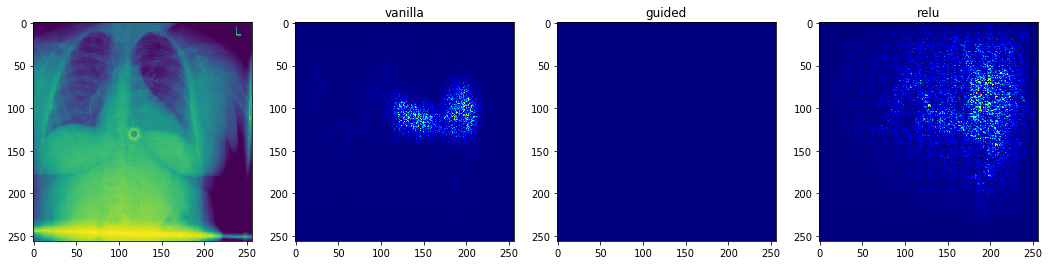

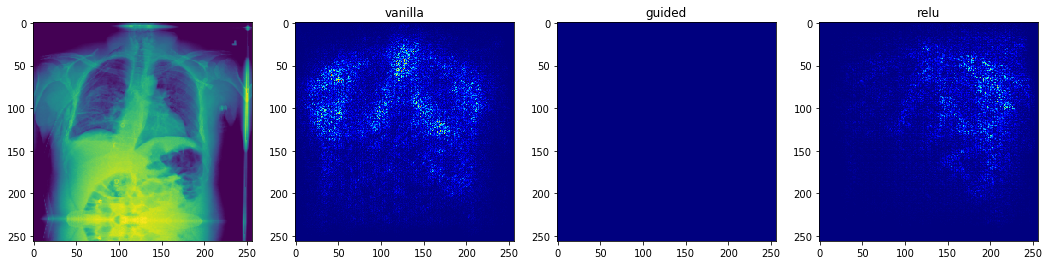

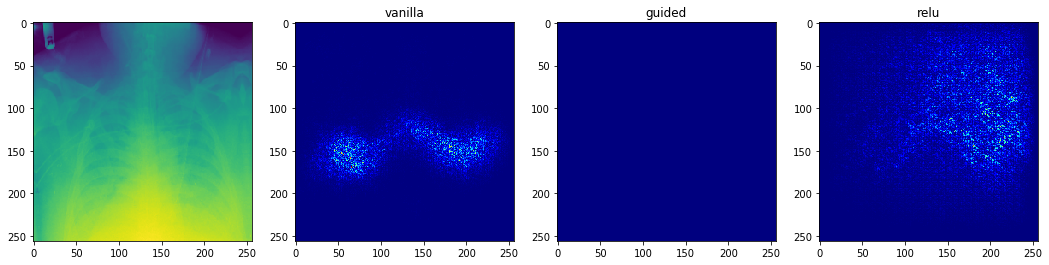

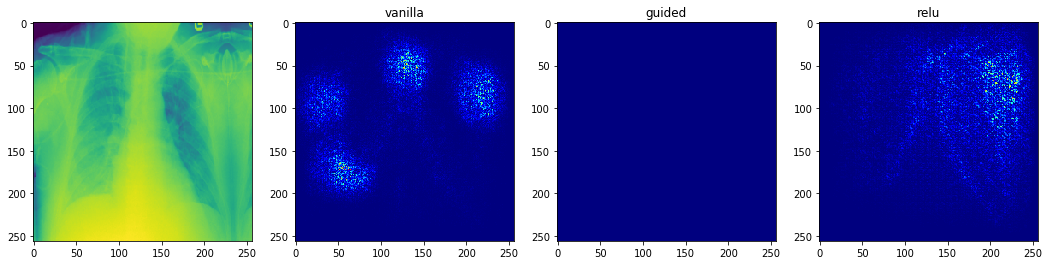

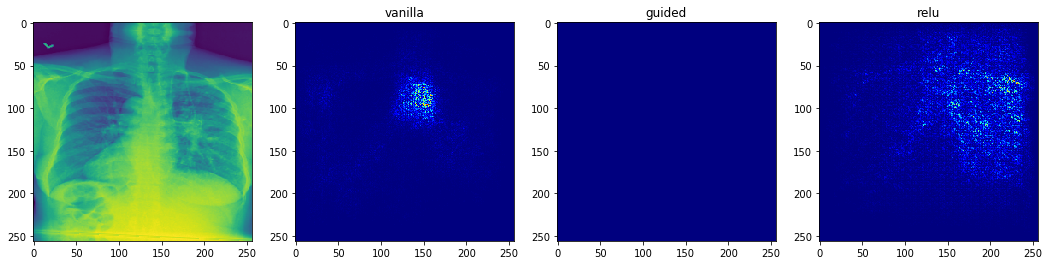

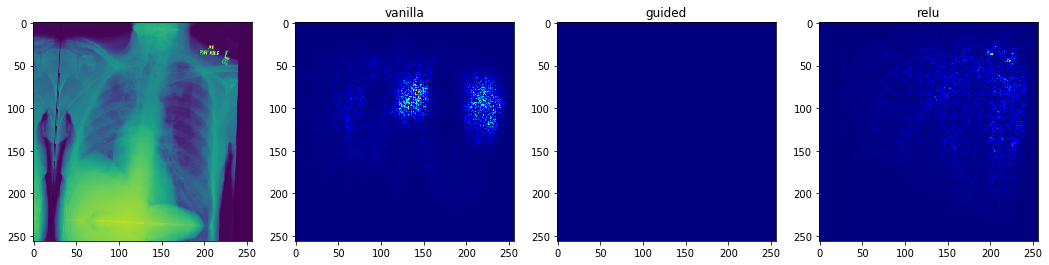

In [48]:
for class_idx in np.arange(10): 
    indices = np.where(test_Y[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_X[idx][..., 0])
 
    for i, modifier in enumerate([None,'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
        seed_input=test_X[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')